<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViTMatte/Quick_inference_with_ViTMatte_for_image_matting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with ViTMatte for image matting

[Image matting](https://paperswithcode.com/task/image-matting) is the task of accurately estimating the foreground object in images and videos. This is used for instance by your phone, when you take a "portrait" selfie, blurring the background (see for instance how Google does this for the [Pixel 6](https://ai.googleblog.com/2022/01/accurate-alpha-matting-for-portrait.html)).

In this notebook, we'll perform inference with the new [ViTMatte](https://arxiv.org/abs/2305.15272) model, which leverages strong pre-trained vision transformers (ViT) for this task, obtaining state-of-the-art results.

ViTMatte only adds a lightweight decoder on top of a plain Vision Transformer, making the backbone do the heavy work.

## Set-up environment

Let's start by installing 🤗 Transformers. We install from source here since the model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00


## Load image and trimap

In image matting, a "hint" that's often used by researchers when developing an image matting algorithm is a so-called **trimap**. A trimap is a manually labeled hint map, where users simply outline the foreground (white) and background (black) for a given image and the matting algorithm then calculates the transparency or so-called alpha values only in the rest unknown regions (grey).

The ViTMatte model expects both the image and trimap as input.



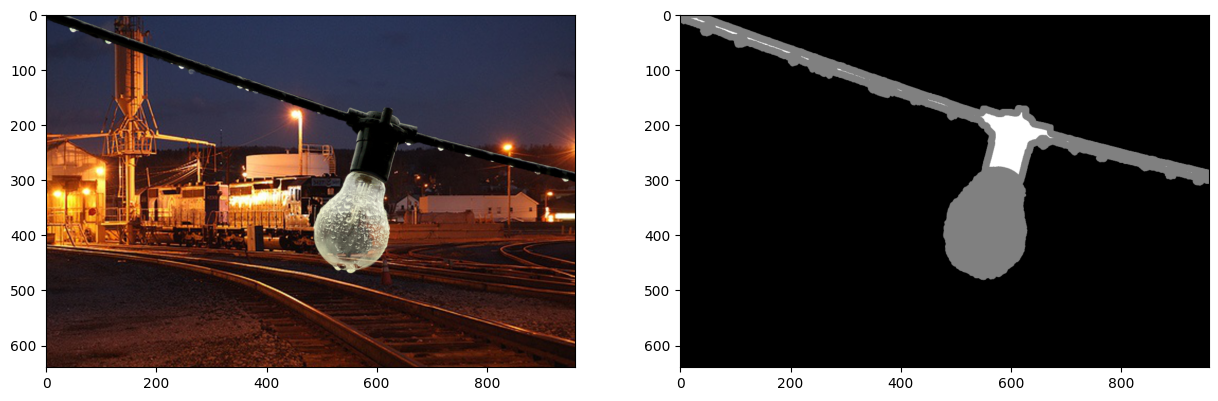

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

url = "https://github.com/hustvl/ViTMatte/blob/main/demo/bulb_rgb.png?raw=true"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
url = "https://github.com/hustvl/ViTMatte/blob/main/demo/bulb_trimap.png?raw=true"
trimap = Image.open(requests.get(url, stream=True).raw)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(trimap)
plt.show()

## Load model

Next, let's load the model and its processor from the 🤗 hub.

In [3]:
from transformers import VitMatteImageProcessor, VitMatteForImageMatting

processor = VitMatteImageProcessor.from_pretrained("hustvl/vitmatte-small-distinctions-646")
model = VitMatteForImageMatting.from_pretrained("hustvl/vitmatte-small-distinctions-646")

In [4]:
# prepare image + trimap for the model
pixel_values = processor(images=image, trimaps=trimap.convert("L"), return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 4, 640, 960])


## Forward pass

Let's run a forward pass and visualize the predicted alpha values.

In [5]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [6]:
outputs.alphas.shape

torch.Size([1, 1, 640, 960])

In [7]:
alphas = outputs.alphas.flatten(0, 2)
alphas.shape

torch.Size([640, 960])

In [8]:
alphas

tensor([[9.8798e-01, 9.9698e-01, 9.9717e-01,  ..., 4.9170e-06, 1.4001e-05,
         3.3409e-04],
        [9.9601e-01, 9.9962e-01, 9.9966e-01,  ..., 1.0447e-07, 3.6842e-07,
         2.6414e-05],
        [9.9630e-01, 9.9962e-01, 9.9966e-01,  ..., 5.6837e-08, 2.0373e-07,
         1.6122e-05],
        ...,
        [4.1553e-06, 1.8253e-08, 1.3348e-08,  ..., 1.3582e-08, 7.4389e-08,
         2.4765e-05],
        [5.6947e-06, 1.1443e-07, 2.0101e-08,  ..., 1.7535e-07, 8.6963e-07,
         1.4364e-04],
        [1.6729e-03, 1.4622e-04, 4.9329e-05,  ..., 2.8684e-05, 2.0366e-04,
         1.6728e-03]])

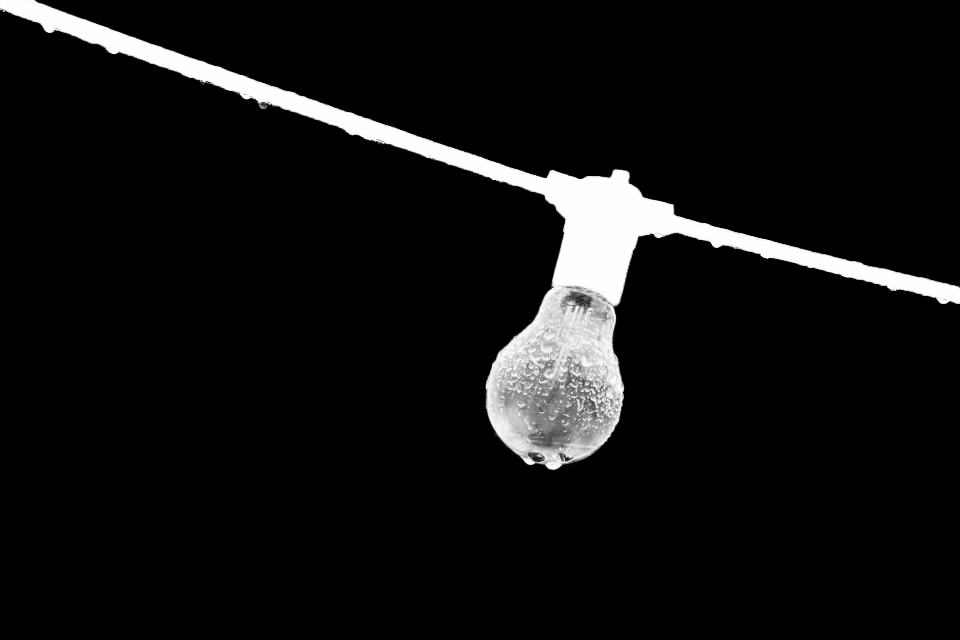

In [9]:
from torchvision.transforms import functional as F

alphas = outputs.alphas.flatten(0, 2)
prediction = F.to_pil_image(alphas)
prediction

## Visualize foreground

We can use the function below to crop the foreground object out of the image.

In [10]:
import PIL

def cal_foreground(image: PIL.Image, alpha: PIL.Image):
    """
    Calculate the foreground of the image.

    Returns:
        foreground: the foreground of the image, numpy array
    """
    image = image.convert("RGB")
    alpha = alpha.convert("L")
    alpha = F.to_tensor(alpha).unsqueeze(0)
    image = F.to_tensor(image).unsqueeze(0)
    foreground = image * alpha + (1 - alpha)
    foreground = foreground.squeeze(0).permute(1, 2, 0).numpy()

    return foreground

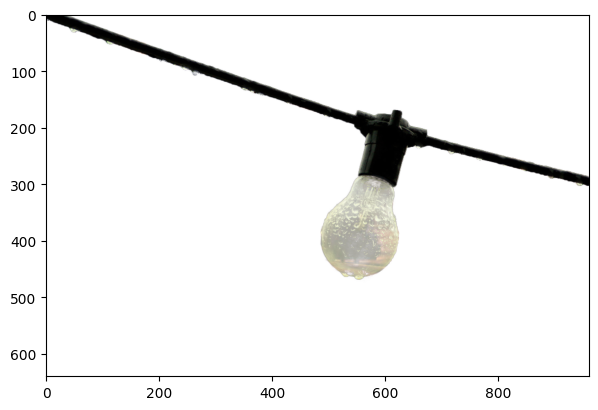

In [11]:
fg = cal_foreground(image, prediction)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()

## Background replacement

Another cool use case of image matting is visalizing the foreground object on a new background of interest.

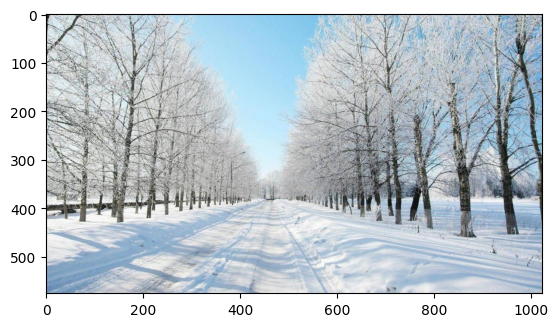

In [12]:
url = "https://github.com/hustvl/ViTMatte/blob/main/demo/new_bg.jpg?raw=true"
background = Image.open(requests.get(url, stream=True).raw).convert("RGB")

plt.imshow(background)

In [13]:
def merge_new_bg(image, background, alpha):
    """
    Merge the alpha matte with a new background.

    Returns:
        foreground: the foreground of the image, numpy array
    """
    image = image.convert('RGB')
    bg = background.convert('RGB')
    alpha = alpha.convert('L')
    image = F.to_tensor(image)
    bg = F.to_tensor(bg)
    bg = F.resize(bg, image.shape[-2:])
    alpha = F.to_tensor(alpha)
    new_image = image * alpha + bg * (1 - alpha)

    new_image = new_image.squeeze(0).permute(1, 2, 0).numpy()
    return new_image

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


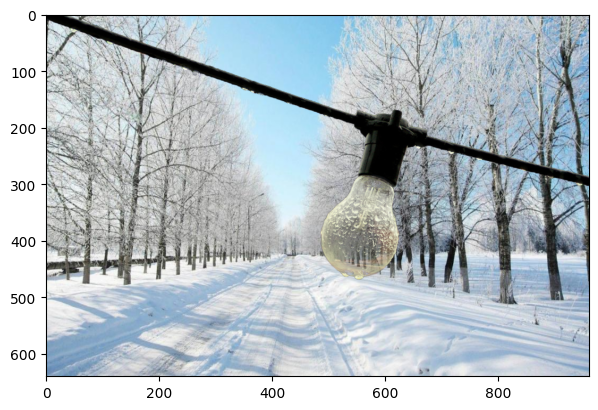

In [14]:
# merge with new background
new_image = merge_new_bg(image, background, prediction)
plt.figure(figsize=(7, 7))
plt.imshow(new_image)
plt.show()